In [1]:
import numpy as np
import pickle, os
from matplotlib import pyplot as plt
from tqdm import tqdm


## Import the Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    var = x.var()  # Variance for normalization
    g = np.correlate((x-mu), (x-mu), mode='full')[tau-1:]
    g = g / var
    n = np.arange(tau,0,-1)
    return g/n

## Load the data

In [5]:
# Load in the omega angles by replica
dt_in_ns = 0.004  # 10 ps per snapshot
nreplicas = 3

omegas_by_replica = []
for i in range(nreplicas):
    # load in the angles
    angles = np.array(Data.load(f'omega_data/omegas_rep{i}.pkl').array_list)
    # shift into (-90, 270) range to avoid periodic boundaries
    omegas_by_replica.append(angles)

omegas_by_replica = np.array(omegas_by_replica)
all_cistrans = omega2cistrans(omegas_by_replica)
# print(omegas_by_replica)

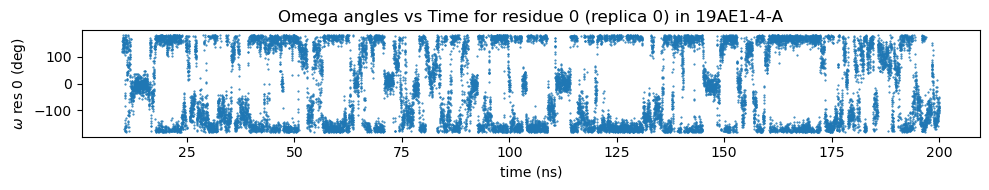

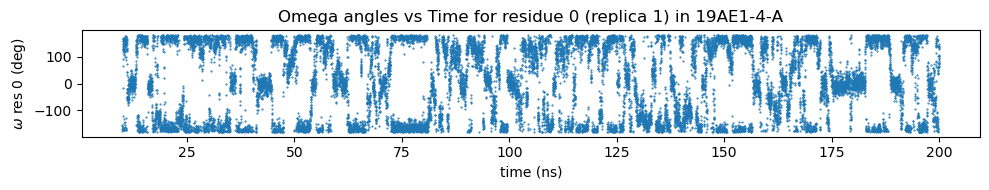

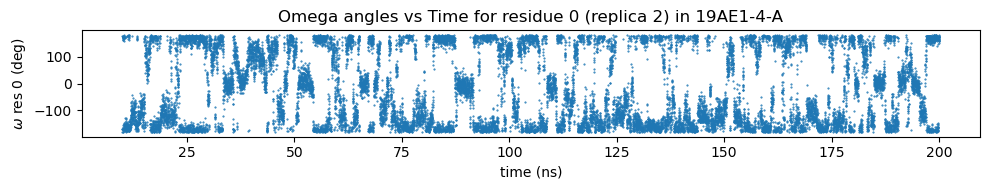

In [7]:
# Plot omega angles vs time for selected residues for each replica
residues_to_plot = [0]
start = 1000
nsnaps = 20000
for i in range(nreplicas):
    plt.figure(figsize=(10, 2))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(len(residues_to_plot), 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, omegas_by_replica[i][start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')
    plt.tight_layout()
#plt.show()

## Calculate the coorelation time, can be skipped, and load the one already calcualted

In [8]:
all_cistrans.shape

(3, 212509, 3)

In [9]:
## Calculate the coorelation time, can be skipped 

# Load in the omega angles by replica
dt_in_ns = 0.004  # 10 ps per snapshot
nreplicas = 3
Nmax = 50000 # Maximum number of steps to display in plots


# Convert list of lists to a NumPy array 
nreplicas, timesteps, residues = all_cistrans.shape # (6, 600030, 3)

# Calculate autocorrelation for each replica and residue
autocorr_results = np.zeros((nreplicas, residues, timesteps))

for i in tqdm(range(nreplicas), desc="Processing Replicas"):
    for j in tqdm(range(residues), desc="Processing Residue"):
        cistrans = all_cistrans[i, :, j]
        autocorr_results[i, j, :] = autocorr(cistrans)
    # After finishing the inner loop, update once

print(autocorr_results.shape)  # Should output (6, 3, 600030)

Processing Replicas: 100%|██████████| 3/3 [00:39<00:00, 13.20s/it]

(3, 3, 212509)


In [10]:
os.makedirs('autocoorel_data', exist_ok=True)

data_instance = Data(autocorr_results)
data_instance.save("autocoorel_data/autocoorelation_res.pkl")

## Load and plot the Autocoor

In [11]:
# To load it back later
autocorr_results = Data.load("autocoorel_data/autocoorelation_res.pkl").array_list
autocorr_results.shape

(3, 3, 212509)

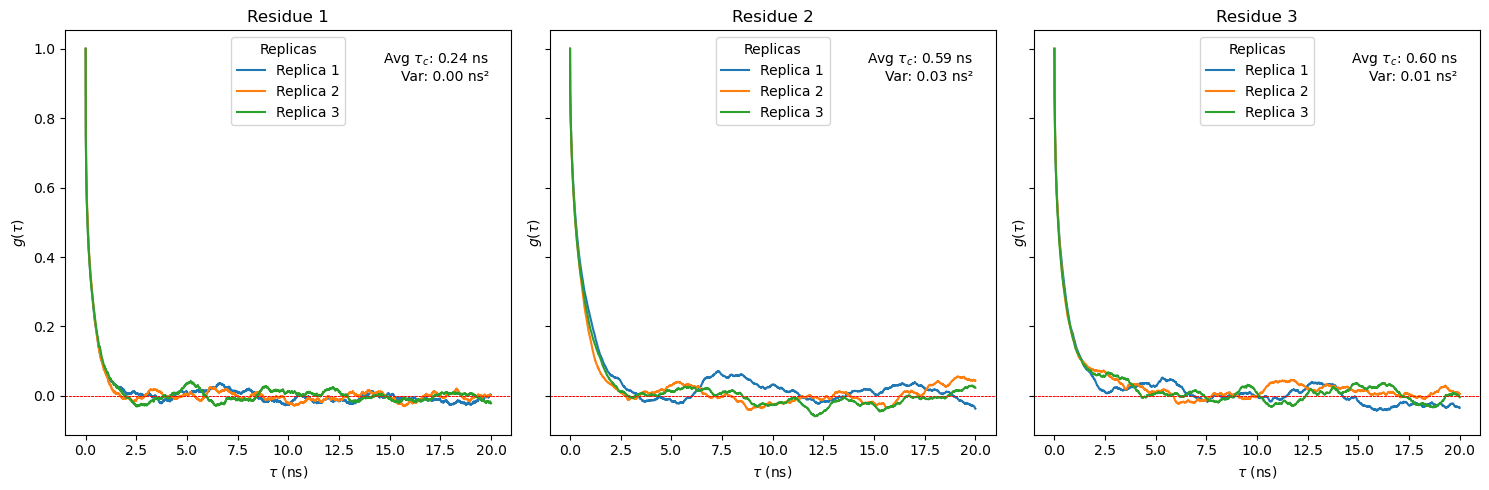

Residue 1: Avg $\tau_c$ = 0.240502 ns, Variance = 0.000521 ns²
Residue 2: Avg $\tau_c$ = 0.592390 ns, Variance = 0.029214 ns²
Residue 3: Avg $\tau_c$ = 0.596072 ns, Variance = 0.009670 ns²


In [14]:
residues = [0,1,2]
nreplicas = 3
Nmax = 5000  # Maximum number of steps to display in plots
dt_in_ns = 0.004  # 4 ps per step (converted to ns)

fig, axes = plt.subplots(1, len(residues), figsize=(15, 5), sharey=True)  # One row, three subplots for residues

# Store average and variance of tau_c for each residue
tau_c_avg = []
tau_c_var = []

for j in range(len(residues)):  # Iterate over residues
    ax = axes[j]
    tau_c_values = []  # Collect tau_c for all replicas for this residue

    for i in range(nreplicas):  # Iterate over replicas
        g = autocorr_results[i, j, :]
        tau_c = np.sum(g[0:Nmax])  # Calculate tau_c
        tau_c_values.append(tau_c * dt_in_ns)  # Convert tau_c to ns

        # Plot autocorrelation for each replica (X-axis in ns)
        ax.plot(np.arange(Nmax) * dt_in_ns, g[:Nmax], label=f'Replica {i+1}')
        ax.axhline(0, color='r', linestyle='--', linewidth=0.5)  # Horizontal zero line

    # Calculate average and variance of tau_c in ns
    tau_c_avg_residue = np.mean(tau_c_values)
    tau_c_var_residue = np.var(tau_c_values)
    tau_c_avg.append(tau_c_avg_residue)
    tau_c_var.append(tau_c_var_residue)

    # Annotate the subplot with average and variance in ns
    ax.text(0.95, 0.95, f'Avg $\\tau_c$: {tau_c_avg_residue:.2f} ns\nVar: {tau_c_var_residue:.2f} ns²',
            transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

    ax.set_xlabel('$\\tau$ (ns)')  # Update X-axis label to ns
    ax.set_ylabel('$g(\\tau)$')
    ax.set_title(f'Residue {j+1}')
    ax.legend(title='Replicas', loc='upper center')

plt.tight_layout()
plt.show()

# Print overall statistics for reference (in ns)
for j in range(len(residues)):
    print(f'Residue {j+1}: Avg $\\tau_c$ = {tau_c_avg[j]:.6f} ns, Variance = {tau_c_var[j]:.6f} ns²')
